In [5]:
import heapq
import itertools
import math
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Helper function: Dijkstra's algorithm to find shortest paths from a single source
def dijkstra(graph, edge_weights, start):
    distances = {vertex: float('infinity') for vertex in graph}
    previous = {vertex: None for vertex in graph}
    distances[start] = 0
    pq = [(0, start)]
    
    while pq:
        current_distance, current_vertex = heapq.heappop(pq)

        if current_distance > distances[current_vertex]:
            continue

        for neighbor in graph[current_vertex]:
            # Get the weight of the edge between current_vertex and neighbor
            weight = edge_weights[(current_vertex, neighbor)]
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous[neighbor] = current_vertex
                heapq.heappush(pq, (distance, neighbor))

    return distances, previous

# Helper function: Find all-pairs shortest paths between odd degree vertices
def find_shortest_paths_between_odd_vertices(graph, edge_weights, odd_vertices):
    shortest_paths = {}
    path_dict = {}
    for i in range(len(odd_vertices)):
        distances, previous = dijkstra(graph, edge_weights, odd_vertices[i])
        for j in range(i + 1, len(odd_vertices)):
            shortest_paths[(odd_vertices[i], odd_vertices[j])] = distances[odd_vertices[j]]
            # Reconstruct the path from the previous nodes
            path = []
            current = odd_vertices[j]
            while current is not None:
                path.append(current)
                current = previous[current]
            path.reverse()
            path_dict[(odd_vertices[i], odd_vertices[j])] = path
            path_dict[(odd_vertices[j], odd_vertices[i])] = path[::-1]  # Reverse path for the opposite direction
    return shortest_paths, path_dict

# Dynamic Programming approach to find the minimum cost matching of odd degree vertices
def minimum_cost_matching(odd_vertices, shortest_paths):
    n = len(odd_vertices)
    dp = [math.inf] * (1 << n)  # DP table to store the minimum cost for each subset
    dp[0] = 0  # Empty set has cost 0
    match = [None] * (1 << n)  # Store the matching pairs

    # Iterate over all subsets of odd vertices
    for mask in range(1 << n):
        # If the number of bits set in 'mask' is odd, skip
        if bin(mask).count('1') % 2 != 0:
            continue
        # Try to pair each two vertices in the subset
        for i in range(n):
            if mask & (1 << i):
                for j in range(i + 1, n):
                    if mask & (1 << j):
                        new_mask = mask ^ (1 << i) ^ (1 << j)
                        vertex1 = odd_vertices[i]
                        vertex2 = odd_vertices[j]
                        cost = dp[new_mask] + shortest_paths[(vertex1, vertex2)]
                        if cost < dp[mask]:
                            dp[mask] = cost
                            match[mask] = (new_mask, vertex1, vertex2)

    # Reconstruct the matching
    mask = (1 << n) - 1
    pairs = []
    while mask:
        new_mask, vertex1, vertex2 = match[mask]
        pairs.append((vertex1, vertex2))
        mask = new_mask

    return dp[(1 << n) - 1], pairs  # Return the minimum cost and the matching pairs

# Function to find Eulerian circuit using Hierholzer's algorithm
def find_eulerian_circuit(graph, start):
    local_graph = defaultdict(list, {u: list(v) for u, v in graph.items()})
    stack = [start]
    circuit = []

    while stack:
        u = stack[-1]
        if local_graph[u]:
            v = local_graph[u].pop()
            stack.append(v)
        else:
            circuit.append(stack.pop())

    return circuit[::-1]  # Reverse to get the correct order

# Main function: Solve the Chinese Postman Problem
def chinese_postman_with_path(graph, edge_weights):
    # 1. Calculate the degree of each vertex
    degrees = {vertex: 0 for vertex in graph}
    for vertex, neighbors in graph.items():
        for neighbor in neighbors:
            degrees[vertex] += 1

    # 2. Find the odd degree vertices
    odd_vertices = [vertex for vertex, degree in degrees.items() if degree % 2 != 0]

    # 3. If there are no odd degree vertices, the graph is already Eulerian
    if not odd_vertices:
        return sum(edge_weights[(vertex, neighbor)] for vertex in graph for neighbor in graph[vertex]) // 2, find_eulerian_circuit(graph, next(iter(graph)))

    # 4. Find shortest paths between odd degree vertices
    shortest_paths, paths = find_shortest_paths_between_odd_vertices(graph, edge_weights, odd_vertices)

    # 5. Use dynamic programming to find the minimum cost of adding edges to make the graph Eulerian
    matching_cost, pairs = minimum_cost_matching(odd_vertices, shortest_paths)

    # 6. Duplicate the matching edges in the graph
    for u, v in pairs:
        path = paths[(u, v)]
        for i in range(len(path) - 1):
            graph[path[i]].append(path[i + 1])
            graph[path[i + 1]].append(path[i])

    # 7. Find Eulerian circuit
    start_vertex = next(iter(graph))
    eulerian_circuit = find_eulerian_circuit(graph, start_vertex)

    # 8. Calculate the total cost (sum of all edges + minimum matching cost)
    total_cost = sum(edge_weights[(vertex, neighbor)] for vertex in graph for neighbor in graph[vertex]) // 2
    return total_cost + matching_cost, eulerian_circuit


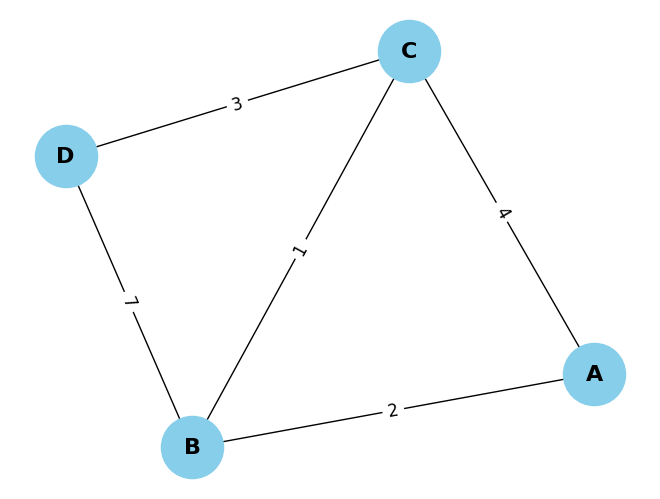

In [9]:
# Define the graph as an adjacency list
graph = {
    'A': ['B', 'C'],
    'B': ['A', 'C', 'D'],
    'C': ['A', 'B', 'D'],
    'D': ['B', 'C']
}

# Corresponding edge weights
edge_weights = {
    ('A', 'B'): 2, ('B', 'A'): 2,
    ('A', 'C'): 4, ('C', 'A'): 4,
    ('B', 'C'): 1, ('C', 'B'): 1,
    ('B', 'D'): 7, ('D', 'B'): 7,
    ('C', 'D'): 3, ('D', 'C'): 3
}

# Create a new graph object using networkx
G = nx.Graph()

# Add nodes and edges to the graph
for node, neighbors in graph.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor, weight=edge_weights[(node, neighbor)])

# Get the positions of nodes for visualization
pos = nx.spring_layout(G)

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=16, font_weight='bold')

# Draw edge labels (the weights of the edges)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Show the plot
plt.show()


In [10]:

# Solve the Chinese Postman Problem and get the path
total_cost, eulerian_circuit = chinese_postman_with_path(graph, edge_weights)
print(f"The total cost of the Chinese Postman tour is: {total_cost}")
print(f"The Eulerian circuit is: {eulerian_circuit}")

The total cost of the Chinese Postman tour is: 19
The Eulerian circuit is: ['A', 'C', 'B', 'C', 'D', 'C', 'B', 'D', 'B', 'C', 'A', 'B', 'A']
